<h2> Fraud Report

In [262]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#select directory that cointain db file

connection = sqlite3.connect('desafio-tecnico.db')
cursor = connection.cursor()

#Tabelas disponíveis
table_list = [a for a in cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

# here is you table list
print(table_list)

[('accounts',), ('address',), ('levels',), ('charges',), ('transactions',), ('transaction_type',)]


<h2> Questions

Qual a quantidade e valor das trasferências ao longo dos dias?

Quantos R$ são transações regulares e fraudulentas?

Quais as horas do dia em que tem mais ocorrências de fraude?

Quais os Estados com maior valor de transações fraudulentas?

Quais as formas de pagamentos mais utilizadas e que geram mais receita?

Quais os usuários com mais transações fraudulentas?

<h2> 1- Qual a quantidade e valor das transações ao longo dos dias?

In [145]:
VW_Trans = pd.read_sql_query("""
    SELECT date(transactions.created_at) as transactionDate,
    SUM(value)/100 as transactionValueRS,
    COUNT(transactions.created_at) transactionsNums
    
    FROM transactions
            
    GROUP BY transactionDate
    """
    ,connection)

VW_Trans['transactionDate'] = (pd.to_datetime(VW_Trans['transactionDate'], format='%Y-%m-%d').dt.date)

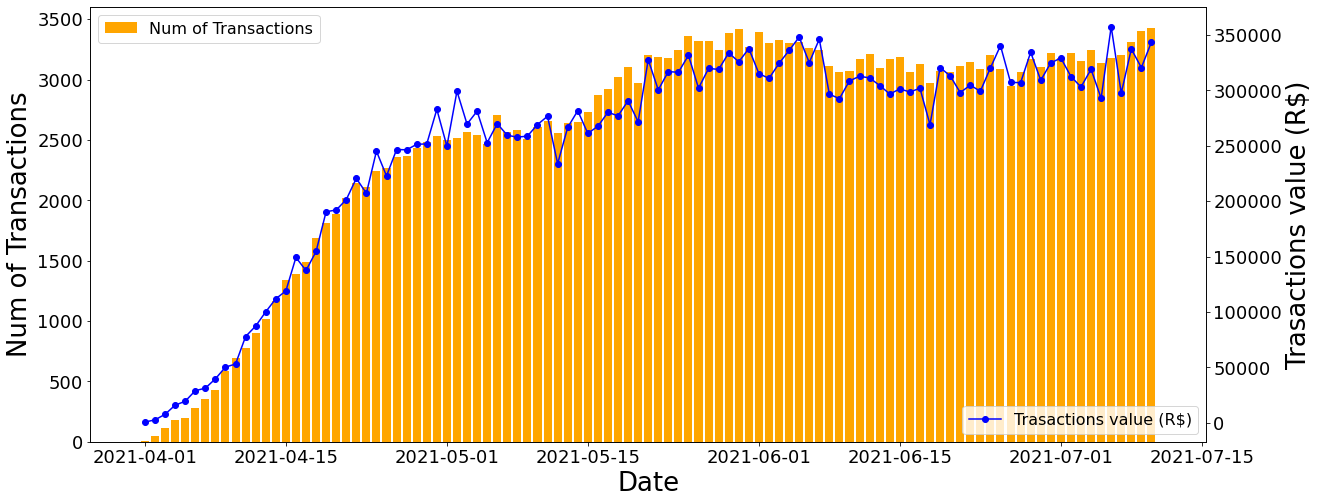

In [420]:
fig,ax=plt.subplots(figsize=(20,8))
ax.bar(VW_Trans.transactionDate, VW_Trans.transactionsNums, color="orange")
ax.set_xlabel("Date",size = 26)
ax.set_ylabel("Num of Transactions",size = 26)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.legend(["Num of Transactions"], prop={'size': 16}, loc= "best")

ax2=ax.twinx()

ax2.plot(VW_Trans.transactionDate, VW_Trans.transactionValueRS,color="blue",marker="o")
ax2.set_ylabel("Trasactions value (R$)",size = 26)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.legend(["Trasactions value (R$)"], prop={'size': 16}, loc= "lower right")

plt.show()

<h2> 2- Qual a quantidade de transações regulares e fraudulentas ao longo dos dias?

In [237]:
VW_fraudTrans = pd.read_sql_query("""
    SELECT date(transactions.created_at) as transactionDate,
    value/100 as value,
    CASE level
        WHEN 'F' THEN '1'
        WHEN 'A' THEN '0'
        WHEN 'B' THEN '0'
        WHEN 'C' THEN '0'
        WHEN 'D' THEN '0'
    END fraud
    
    FROM levels
            
    left join transactions as transactions on transactions.account_number = levels.account_number 
    WHERE fraud IS NOT NULL and value IS NOT NULL
    """
    ,connection)

VW_fraudTrans['transactionDate'] = (pd.to_datetime(VW_fraudTrans['transactionDate'], format='%Y-%m-%d').dt.date)
VW_fraudTrans['fraud'] = VW_fraudTrans['fraud'].astype(int)
VW_fraudTrans['value'] = VW_fraudTrans['value'].astype(int)

VW_amoutTrans = pd.DataFrame((VW_fraudTrans.groupby(VW_fraudTrans['transactionDate'])['value'].count())).reset_index()
VW_valueFraudTrans = pd.DataFrame((VW_fraudTrans.groupby(VW_fraudTrans['transactionDate'])['fraud'].sum())).reset_index()

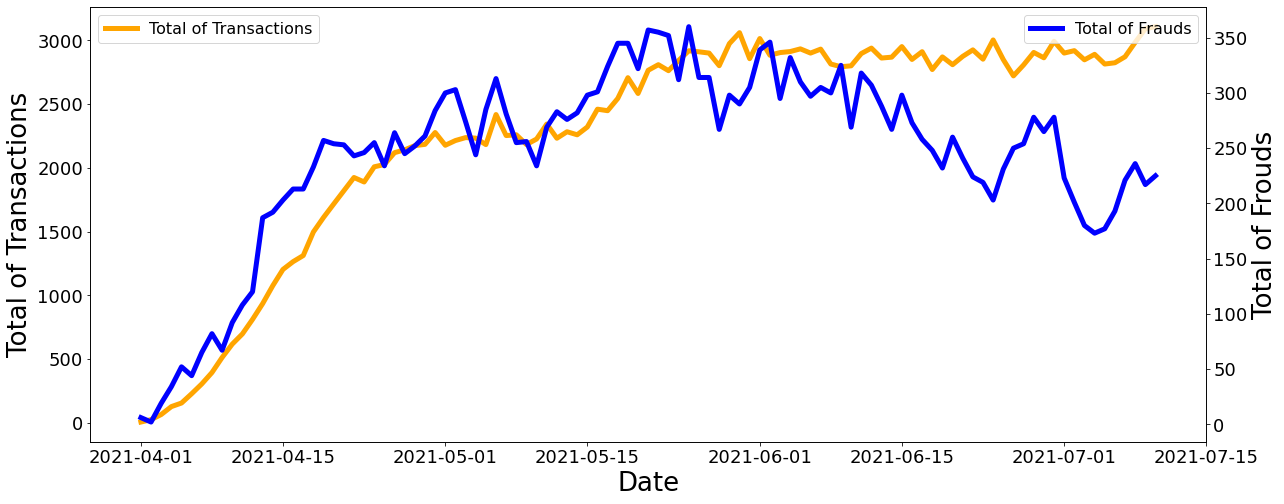

In [456]:
fig,ax=plt.subplots(figsize=(20,8))
ax.plot(VW_amoutTrans.transactionDate, VW_amoutTrans.value, color="orange", linewidth = 5, label='y0')
ax.set_xlabel("Date",size = 26)
ax.set_ylabel("Total of Transactions",size = 26)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

plt.legend(["Total of Transactions"], prop={'size': 16}, loc= "best")

ax2=ax.twinx()

ax2.plot(VW_valueFraudTrans.transactionDate, VW_valueFraudTrans.fraud,color="blue", linewidth = 5, label='w')
ax2.set_ylabel("Total of Frouds",size = 26)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 18)

plt.legend(["Total of Frauds"], prop={'size': 16}, loc= "best")

plt.show()

<h2> 3- Quais horas do dia ocorrem mais fraudes?

In [388]:
VW_fraudHours = pd.read_sql_query("""
    SELECT time(transactions.created_at) as transactionDate,
    CASE level
        WHEN 'F' THEN '1'
        WHEN 'A' THEN '0'
        WHEN 'B' THEN '0'
        WHEN 'C' THEN '0'
        WHEN 'D' THEN '0'
    END fraud
    
    FROM levels
            
    left join transactions as transactions on transactions.account_number = levels.account_number 
    WHERE fraud IS NOT NULL and value IS NOT NULL and fraud = '1'
    """
    ,connection)

VW_fraudHours['fraud'] = VW_fraudHours['fraud'].astype(int)

VW_fraudHours = pd.DataFrame((VW_fraudHours.groupby(VW_fraudHours['transactionDate'])['fraud'].count())).reset_index()

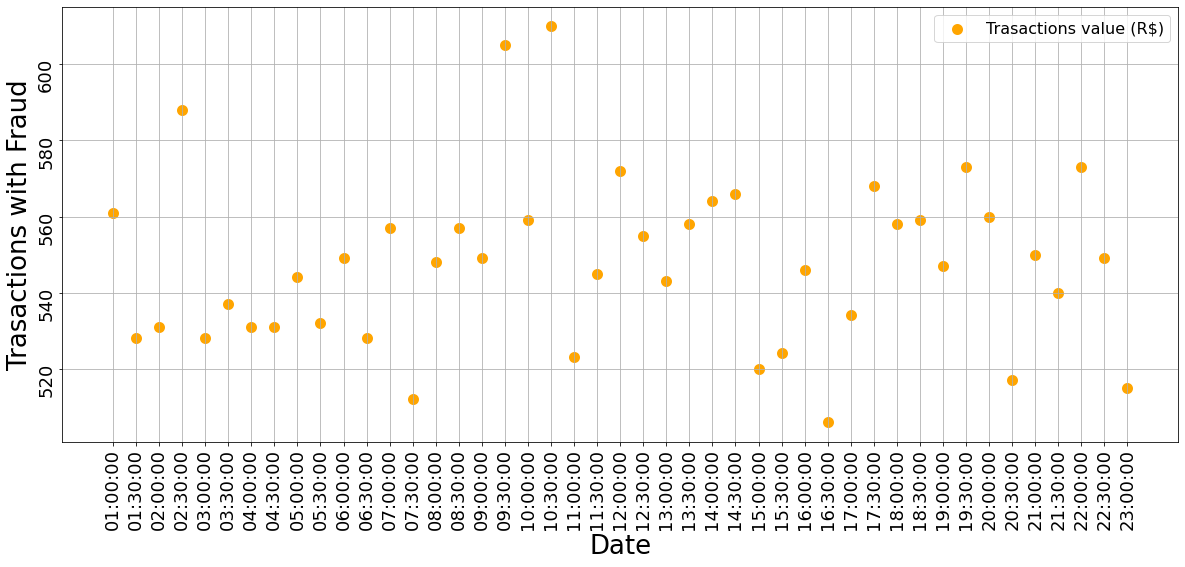

In [392]:
fig,ax=plt.subplots(figsize=(20,8))
ax.scatter(VW_fraudHours.transactionDate, VW_fraudHours.fraud, color="orange", linewidth = 5, label='y0')
ax.set_xlabel("Date",size = 26)
ax.set_ylabel("R$ - Trasactions with Fraud",size = 26)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18,rotation= 90)

plt.legend(["Trasactions value (R$)"], prop={'size': 16}, loc= "best")

plt.grid()
plt.show()

<h2> 4- Quais os Estados com maior valor em transações fraudulentas?


In [424]:
VW_fraudStated = pd.read_sql_query("""
    SELECT state,
    value/100000 as value,
    CASE level
        WHEN 'F' THEN '1'
        WHEN 'A' THEN '0'
        WHEN 'B' THEN '0'
        WHEN 'C' THEN '0'
        WHEN 'D' THEN '0'
    END fraud
    
    FROM accounts
            
    left join transactions as transactions on accounts.account_number = transactions.account_number 
    left join levels as levels on accounts.account_number = levels.account_number 
    left join address as address on accounts.address_id = address.id 

    WHERE fraud IS NOT NULL and value IS NOT NULL and fraud = '1'
    """
    ,connection)

VW_fraudStated['value'] = VW_fraudStated['value'].astype(float)

VW_fraudStated = pd.DataFrame((VW_fraudStated.groupby(VW_fraudStated['state'])['value'].sum())).reset_index()

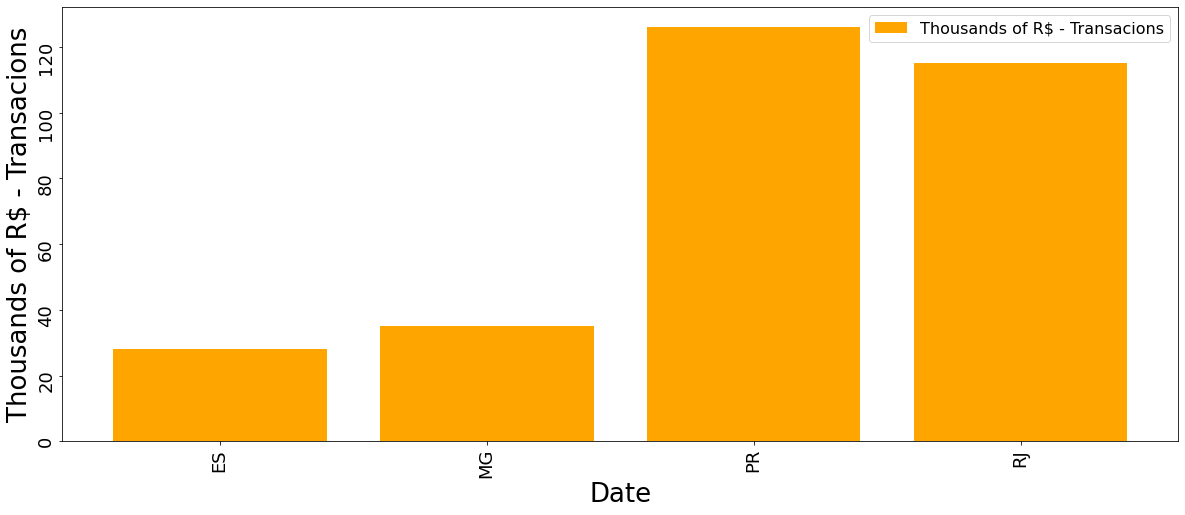

In [426]:
fig,ax=plt.subplots(figsize=(20,8))
ax.bar(VW_fraudStated.state, VW_fraudStated.value, color="orange", linewidth = 5, label='y0')
ax.set_xlabel("Date",size = 26)
ax.set_ylabel("Thousands of R$ - Transacions",size = 26)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18,rotation= 90)

plt.legend(["Thousands of R$ - Transacions"], prop={'size': 16}, loc= "best")

plt.show()

<h2> 5- Quais são as formas de pagamentos mais utilizadas em fraudes?

In [433]:
VW_fraudDesc = pd.read_sql_query("""
    SELECT description,
    value/100000 as value,
    CASE level
        WHEN 'F' THEN '1'
        WHEN 'A' THEN '0'
        WHEN 'B' THEN '0'
        WHEN 'C' THEN '0'
        WHEN 'D' THEN '0'
    END fraud
    
    FROM accounts
            
    left join transactions as transactions on accounts.account_number = transactions.account_number 
    left join transaction_type as transaction_type on transaction_type.id = transactions.transaction_type_id 
    left join levels as levels on accounts.account_number = levels.account_number 
    
    WHERE fraud IS NOT NULL and value IS NOT NULL and fraud = '1'
    """
    ,connection)

VW_fraudDesc['value'] = VW_fraudDesc['value'].astype(float)

VW_fraudDesc = pd.DataFrame((VW_fraudDesc.groupby(VW_fraudDesc['description'])['value'].sum())).reset_index()

In [436]:
#100% das fraudes utilizaram pix_enviado como formo de pagamento
VW_fraudDesc.value_counts()

description      value
boleto_recebido  0.0      1
pix_enviado      304.0    1
pix_recebido     0.0      1
dtype: int64

<h2> 6- Quais 5 os usuários com mais transações fraudulentas?

In [459]:
VW_fraudAcc = pd.read_sql_query("""
    SELECT accounts.account_number,
    occupation,
    email,
    value,
    CASE level
        WHEN 'F' THEN '1'
        WHEN 'A' THEN '0'
        WHEN 'B' THEN '0'
        WHEN 'C' THEN '0'
        WHEN 'D' THEN '0'
    END fraud
    
    FROM accounts
            
    left join transactions as transactions on accounts.account_number = transactions.account_number 
    left join levels as levels on accounts.account_number = levels.account_number 
    
    WHERE fraud IS NOT NULL and value IS NOT NULL and fraud = '1'
    """
    ,connection)

VW_fraudAcc['value'] = VW_fraudAcc['value'].astype(float)

VW_fraudAcc = pd.DataFrame((VW_fraudAcc.groupby(VW_fraudAcc['account_number'])['value'].sum())).reset_index()
VW_fraudAcc = VW_fraudAcc.sort_values("value",ascending = False)


VW_fraudAcc.head(5)

,account_number,value
30,92447,4619607.0
130,654031,4288034.0
47,194782,4215332.0
49,199219,4155965.0
168,871021,4113460.0
